# Importing TensorFlow

In [1]:
!nvidia-smi

Tue Jun 18 19:36:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8              2W /  100W |      14MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
#os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [3]:
import tensorflow as tf
print(tf.__version__)

2024-06-18 19:37:01.324926: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 19:37:01.416855: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 19:37:01.416895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 19:37:01.433256: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 19:37:01.476176: I tensorflow/core/platform/cpu_feature_guar

2.15.0


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import visualkeras

# Preparing data

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255.)

train_generator = datagen.flow_from_directory(
    "male_female_data/Training/",
    target_size=(100,100),
    batch_size=32,
    class_mode="binary"
)

val_generator = datagen.flow_from_directory(
    "male_female_data/Validation",
    target_size=(100,100),
    batch_size=32,
    class_mode="binary"
)

Found 47009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


In [6]:
batch_num = 30
sample_num = 7
img = val_generator[batch_num][0][sample_num]
label = val_generator[batch_num][1][sample_num]

In [7]:
tf.reduce_min(img), tf.reduce_max(img)

2024-06-18 19:37:07.977980: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6070 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

Batch: 30, Sample: 7
Label: 0.0


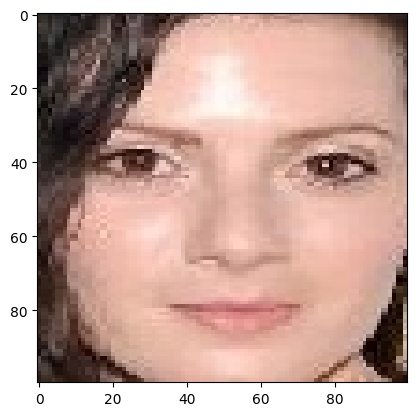

In [8]:
print(f"Batch: {batch_num}, Sample: {sample_num}\nLabel: {label}")
plt.imshow(img)

In [9]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model_checkpoint/cp.weights.h5",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    verbose=0
)

In [10]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


# Creating and trainig cnn model

In [11]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[100,100,3]),
    tf.keras.layers.Conv2D(16, 3, 1, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(2,2, padding="same"),
    tf.keras.layers.Conv2D(32, 3, 1, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(2,2, padding="same"),
    tf.keras.layers.Conv2D(64, 3, 1, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(2,2, padding="same"),
    tf.keras.layers.Conv2D(128, 3, 1, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(2,2, padding="same"),
    tf.keras.layers.Conv2D(256, 3, 1, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(2,2, padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [12]:
cnn_model.compile(
    loss = tf.keras.losses.binary_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [13]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 64)        0

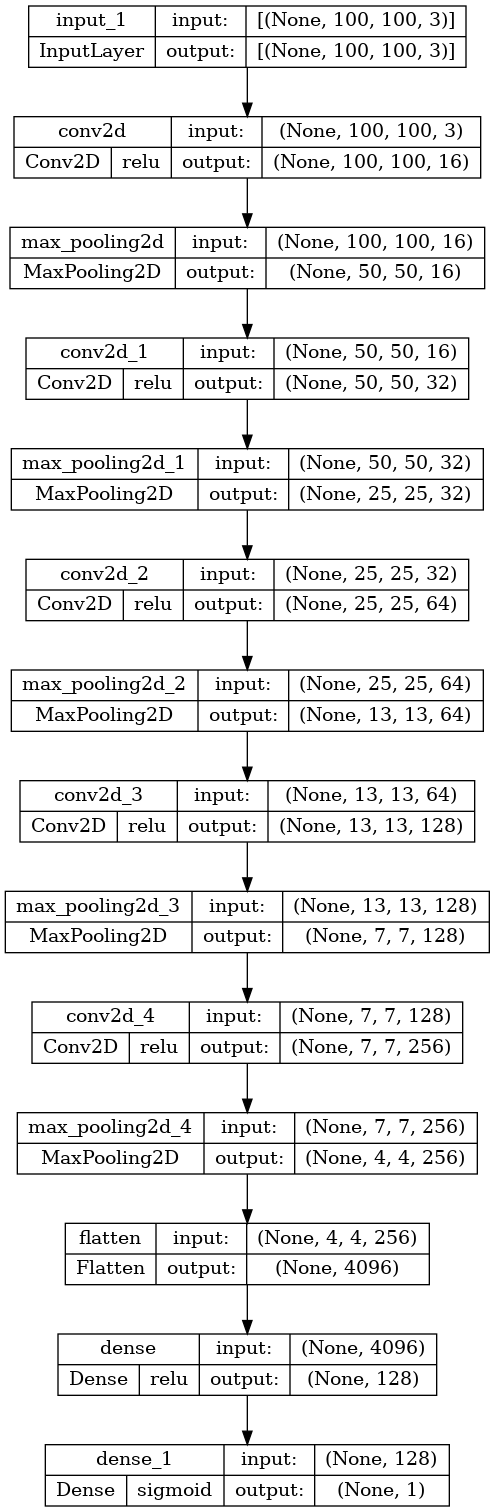

In [14]:
tf.keras.utils.plot_model(cnn_model, show_layer_activations=True, show_shapes=True)

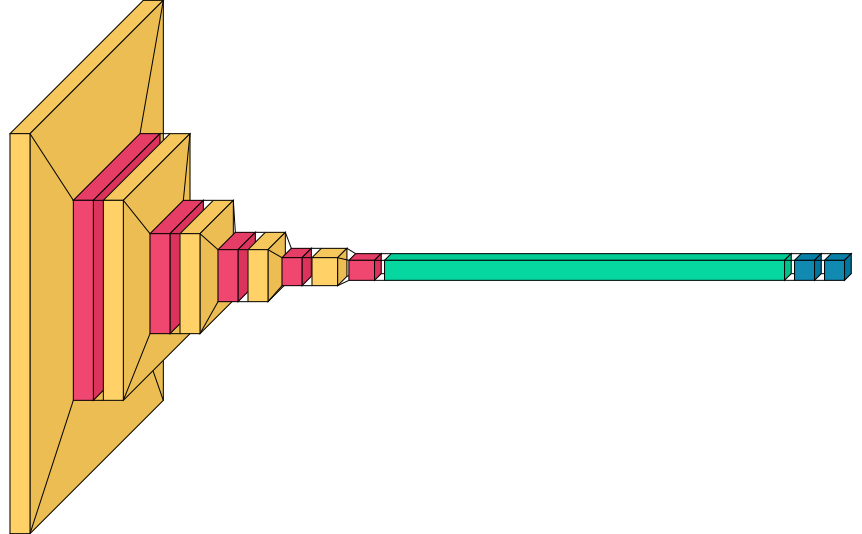

In [15]:
visualkeras.layered_view(cnn_model)

In [16]:
cnn_history = cnn_model.fit(
    x = train_generator,
    validation_data = val_generator,
    epochs = 10,
    callbacks = [model_checkpoint]
)

Epoch 1/10


2024-06-18 19:37:22.097891: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-18 19:37:22.207265: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-06-18 19:37:22.324604: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-18 19:37:23.812290: I external/local_xla/xla/service/service.cc:168] XLA service 0x71a764003980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-18 19:37:23.812319: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-06-18 19:37:23.820938: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718728643.867692   28234 devic

1470/1470 [==============================] - 25s 15ms/step - loss: 0.2253 - accuracy: 0.9072 - val_loss: 0.1153 - val_accuracy: 0.9569
Epoch 2/10
1470/1470 [==============================] - 14s 9ms/step - loss: 0.1279 - accuracy: 0.9535 - val_loss: 0.1029 - val_accuracy: 0.9639
Epoch 3/10
1470/1470 [==============================] - 13s 9ms/step - loss: 0.1125 - accuracy: 0.9592 - val_loss: 0.1203 - val_accuracy: 0.9558
Epoch 4/10
1470/1470 [==============================] - 14s 9ms/step - loss: 0.0984 - accuracy: 0.9639 - val_loss: 0.0932 - val_accuracy: 0.9666
Epoch 5/10
1470/1470 [==============================] - 13s 9ms/step - loss: 0.0921 - accuracy: 0.9672 - val_loss: 0.0950 - val_accuracy: 0.9668
Epoch 6/10
1470/1470 [==============================] - 13s 9ms/step - loss: 0.0816 - accuracy: 0.9709 - val_loss: 0.1040 - val_accuracy: 0.9585
Epoch 7/10
1470/1470 [==============================] - 13s 9ms/step - loss: 0.0723 - accuracy: 0.9738 - val_loss: 0.1078 - val_accuracy: 0.

<Axes: >

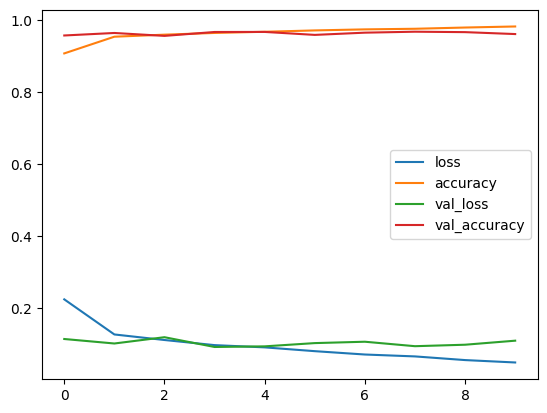

In [17]:
pd.DataFrame(cnn_history.history).plot()

# Creating and training resnet model

In [18]:
base_model = tf.keras.applications.ResNet50(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=[100,100,3])
x = tf.keras.layers.Rescaling(255)(inputs),
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

resnet_model = tf.keras.models.Model(inputs, outputs)

In [19]:
resnet_model.compile(
    loss = tf.keras.losses.binary_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [20]:
resnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 2049 (8.0

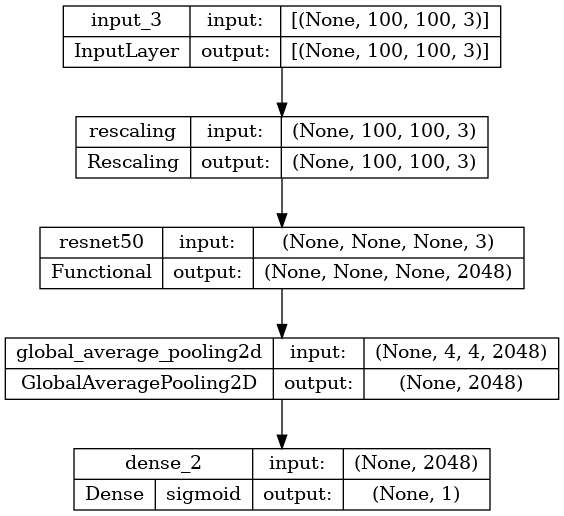

In [21]:
tf.keras.utils.plot_model(resnet_model, show_layer_activations=True, show_shapes=True)

In [24]:
resnet_history = resnet_model.fit(
    x = train_generator,
    validation_data = val_generator,
    epochs = 10,
    callbacks = [model_checkpoint]
)

Epoch 1/10
1470/1470 [==============================] - 18s 12ms/step - loss: 0.1918 - accuracy: 0.9275 - val_loss: 0.1854 - val_accuracy: 0.9270
Epoch 2/10
1470/1470 [==============================] - 18s 12ms/step - loss: 0.1875 - accuracy: 0.9287 - val_loss: 0.1818 - val_accuracy: 0.9287
Epoch 3/10
1470/1470 [==============================] - 18s 12ms/step - loss: 0.1825 - accuracy: 0.9309 - val_loss: 0.1927 - val_accuracy: 0.9239
Epoch 4/10
1470/1470 [==============================] - 18s 12ms/step - loss: 0.1795 - accuracy: 0.9308 - val_loss: 0.1739 - val_accuracy: 0.9308
Epoch 5/10
1470/1470 [==============================] - 18s 12ms/step - loss: 0.1782 - accuracy: 0.9332 - val_loss: 0.1824 - val_accuracy: 0.9300
Epoch 6/10
1470/1470 [==============================] - 18s 12ms/step - loss: 0.1765 - accuracy: 0.9326 - val_loss: 0.1774 - val_accuracy: 0.9296
Epoch 7/10
1470/1470 [==============================] - 18s 12ms/step - loss: 0.1756 - accuracy: 0.9331 - val_loss: 0.1766 -

<Axes: >

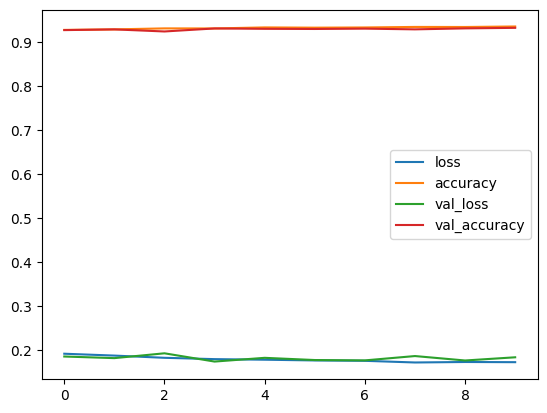

In [25]:
pd.DataFrame(resnet_history.history).plot()

# Model comp.

In [26]:
print("cnn_model")
cnn_model_eval = cnn_model.evaluate(val_generator)

print("\nresnet_model")
resnet_model_eval = resnet_model.evaluate(val_generator)

cnn_model
365/365 [==============================] - 2s 7ms/step - loss: 0.1107 - accuracy: 0.9609

resnet_model
365/365 [==============================] - 3s 9ms/step - loss: 0.1836 - accuracy: 0.9322


# Summary

cnn_model performed better on training and validation accuracy.

cnn_model performed slightly better on predicting time.